In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
housing_data = pd.read_csv('AmesHousing.tsv', delimiter='\t')
housing_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
housing_data.shape

(2930, 82)

# Functions for transforming, selecting and train/testing dataset

We'll create functions to transform, select and train/test the dataset.

In [4]:
#transforming features
def transform_features(df):
    null_list = df.isnull().sum() #list of columns with sum of missing values
    missing_val_cols_lessthan5 = null_list[null_list<(df.shape[0]*0.05)].index #column names with missing values of less than 5%
    df = df[missing_val_cols_lessthan5]
    return(df)
    
#selecting features
def select_features(df):
    df_with_features = df[['Overall Qual', 'SalePrice']]
    return(df_with_features)
    
#training and testing dataset
def train_and_test(df):
    train = df.loc[:(len(df)/2 - 1)]
    train_with_features = select_features(train)
    test = df.loc[(len(df)/2):]
    test_with_features = select_features(test)
    train_col = train_with_features.columns[train_with_features.columns!='SalePrice']
    
    lr = linear_model.LinearRegression()
    lr.fit(train_with_features[train_col], train_with_features['SalePrice'])
    predictions = lr.predict(test[train_col])
    rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions))
    return(rmse)

In [5]:
#testing functions
train_and_test(housing_data)

49555.274538341248

We just used `Overall Qual` as a test run of the functions. We got RMSE of 49555. Let's see if we can improve this error score.

# Tranforming Features

In [6]:
data = transform_features(housing_data.copy())
data.shape

(2930, 71)

Let's add a column for `years_until_remod` using `Year Remod/Add` and `Year Built`. We will also drop some columns that won't be helpful for the analysis due to irrelevance or data leakage.

In [7]:
#new column for years until remodeling
data['years_until_remod'] = data['Year Remod/Add'] - data['Year Built']

#columns to drop
drop_col = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Remod/Add', 'Year Built',
            'Sale Condition', 'Sale Type'] #columns to drop
data = data.drop(drop_col, axis=1)
data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'Paved Drive', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
 

Replacing null values with the most commonly found values.

In [8]:
data = data.fillna(data.mode().iloc[0])
data.isnull().sum().value_counts()

0    64
dtype: int64

# Feature Selection

Let's explore the features and see if there are any outstanding correlations with `SalePrice`.

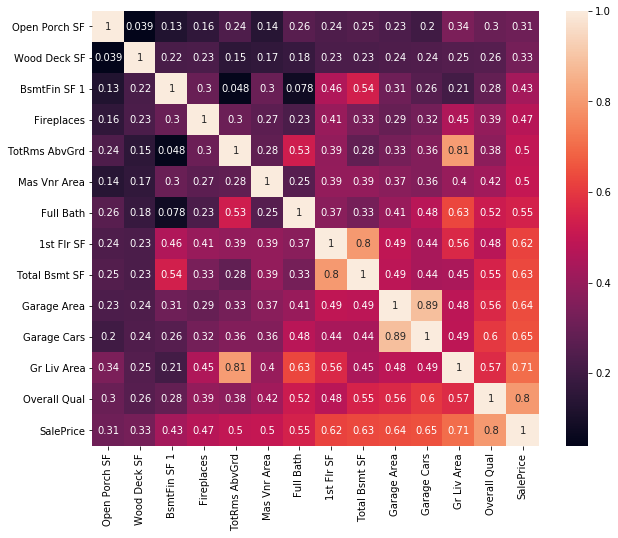

In [9]:
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.3]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[strong_correlations.index].corr(), 
            annot=True)

Some variables have high correlations with each other
* `Totrms AbvGrd` and `Gr Liv Area`
* `1st Flr SF` and `Total Bsmt SF`
* `Garage Area` and `Garage Cars`

To mitigate collinearity, we'll drop `Totrms AbvGrd`, `Total Bsmt SF`, and `Garage Cars`.

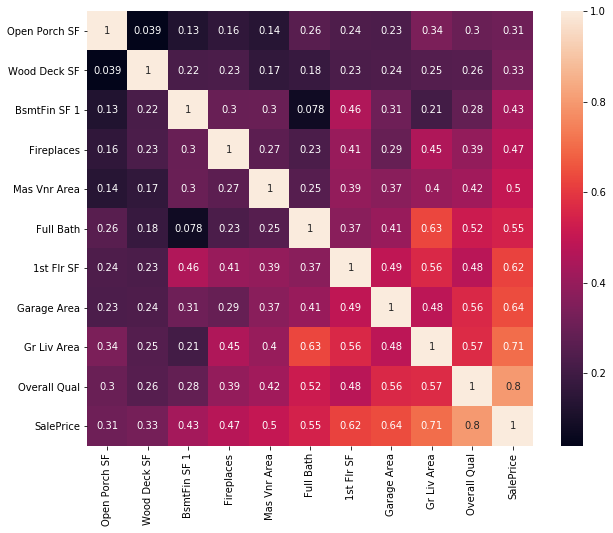

In [10]:
data = data.drop(['TotRms AbvGrd', 'Total Bsmt SF', 'Garage Cars'], axis=1)
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.3]

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data[strong_correlations.index].corr(), 
            annot=True)

With the dropped columns and using 0.6 as the coefficient cut-off line, we can see that `1st Flr SF`, `Garage Area`, `Gr Liv Area` and `Overall Qual` may be good features to use for our model. But we're not done yet! There are some columns that need to be converted into categorical variables, and some of these may be helpful in strengthening our model. There are two types of columns that need to be converted into categorical variables:
1. Columns with object values
2. Columns with numerical values that are nominal in nature

Columns with object values are easy to filter by coding. In this dataset, there aren't any numerical values that are nominal in nature.

In [11]:
categorical_columns = list(data.select_dtypes(include=['object']).columns)
print(categorical_columns)

['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Paved Drive']


# Categorical Variables

To use these features in our model, we need to transform them into numerical representations. We will convert them into a categorical data type.

The main issue here is that linear regression operates under the assumption that the features are linearly correlated with the target column. For the categorical feature, there's no actual numerical meaning to the categorical codes that pandas assigned for that column. To work around this issue, we will use dummy codes for some of these columns. Since columns have varying amounts of unique categorical values and/or they might not have low variance in their unique values, we will drop columns with:
1. The number of unique values greater than 10
2. More than 95% of the values belong in a specific category

After this, we will convert these columns into dummy columns and delete the original columns.

In [12]:
for column in categorical_columns:
    data[column] = data[column].astype('category')
    data_95_percent = data.shape[0] * 0.95 #95% of data
    if (len(data[column].unique()) > 10) or (any(data[column].value_counts() > data_95_percent)):
        data = data.drop(column, axis=1)
    else:
        dummies = pd.get_dummies(data[column], drop_first=True,prefix=str(column))
        data = pd.concat([data, dummies], axis=1)
        data = data.drop([column], axis=1)
data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

# Principal Component Analysis

To mitigate multicollinearity and decrease the number of columns we have now, here are some of the steps we will take:
1. Filter in columns only with correlation coefficient of > 0.5
2. Normalize values
3. Run PCA to create a new dataframe

In [13]:
correlations = data.corr()
sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
strong_correlations = sorted_correlations[sorted_correlations > 0.5] #correlation coefficient higher than 0.5
data = data[strong_correlations.index]
data.head()

,Bsmt Qual_TA,Mas Vnr Area,Foundation_PConc,Kitchen Qual_TA,Full Bath,Exter Qual_TA,1st Flr SF,Garage Area,Gr Liv Area,Overall Qual,SalePrice
0,1,112.0,0,1,1,1,1656,528.0,1656,6,215000
1,1,0.0,0,1,1,1,896,730.0,896,5,105000
2,1,108.0,0,0,1,1,1329,312.0,1329,6,172000
3,1,0.0,0,0,2,0,2110,522.0,2110,7,244000
4,0,0.0,1,1,2,1,928,482.0,1629,5,189900


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#standardizing features (mean = 0 and variance = 1)
x = data.loc[:, data.columns!='SalePrice'].values
x = StandardScaler().fit_transform(x)

#principal component analysis
pca = PCA(whiten=True)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents)
new_data = pd.concat([principal_df, data['SalePrice']], axis = 1)

In [15]:
new_data.head()

,0,1,2,3,4,5,6,7,8,9,SalePrice
0,-0.469225,1.675391,0.301392,-1.119833,-0.362882,0.717509,0.281723,-0.838790,-0.106423,0.199843,215000
1,-0.972335,0.376538,0.629801,-1.063445,-1.652388,-1.659258,0.018913,0.278126,0.511043,-0.265714,105000
2,-0.519994,0.436620,0.803408,-1.157554,1.684100,0.312373,0.180708,0.199601,-1.459510,-0.986394,172000
3,0.726350,1.303071,-1.054342,-2.633212,2.019807,0.673965,-0.518306,-0.025919,1.396267,-0.117346,244000
4,-0.076438,-0.515234,-1.453204,1.419193,-1.706870,0.264713,1.102582,0.486624,-0.440015,0.652271,189900


# Updating functions

It's time for us to update our `tranform_features` and `select_feature` functions.

In [16]:
def transform_features(df):
    null_list = df.isnull().sum() #list of columns with sum of missing values
    missing_val_cols_lessthan5 = null_list[null_list<(df.shape[0]*0.05)].index #column names with missing values of less than 5%
    df = df.loc[:,missing_val_cols_lessthan5]
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']

    #columns to drop
    drop_col = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Remod/Add', 'Year Built',
                'Sale Condition', 'Sale Type']
    df = df.drop(drop_col, axis=1)
    df = df.fillna(df.mode().iloc[0])
    
    #categorical and dummy variables
    categorical_columns = list(df.select_dtypes(include=['object']).columns)
    for column in categorical_columns:
        df[column] = df[column].astype('category')
        df_95_percent = df.shape[0] * 0.95 #95% of data
        if (len(df[column].unique()) > 10) or (any(df[column].value_counts() > df_95_percent)):
            df = df.drop(column, axis=1)
        else:
            dummies = pd.get_dummies(df[column], drop_first=True, prefix=str(column))
            df = pd.concat([df, dummies], axis=1)
            df = df.drop([column], axis=1)
            
    return(df)
    
def select_features(df):
    #dropping collinear columns
    df = df.drop(['TotRms AbvGrd', 'Total Bsmt SF', 'Garage Cars'], axis=1)
    
    #filtering columns with high correlation coefficients
    correlations = df.corr()
    sorted_correlations = np.abs(correlations['SalePrice']).sort_values()
    strong_correlations = sorted_correlations[sorted_correlations > 0.4]
    df = df[strong_correlations.index]
    
    #standardizing features (mean = 0 and variance = 1)
    x = df.loc[:, df.columns!='SalePrice'].values
    x = StandardScaler().fit_transform(x)

    #principal component analysis
    pca = PCA(whiten=True)
    principal_components = pca.fit_transform(x)
    principal_df = pd.DataFrame(data = principal_components)
    df = pd.concat([principal_df, df['SalePrice']], axis = 1)    
    return(df)

Lastly, to bootstrap our model, we will add cross-validation to the `train_and_test` function.

In [17]:
from sklearn.model_selection import cross_val_score, KFold

def train_and_test(df):
    #folding with k value of 10
    kf = KFold(10, shuffle=True, random_state=2)
    
    #applying functions to transform and select features
    df = transform_features(df.copy())
    df = select_features(df.copy())
    
    #train and test
    train_col = df.columns[df.columns!='SalePrice']
    lr = linear_model.LinearRegression()
    mses = cross_val_score(lr, df[train_col], df['SalePrice'], 
                           scoring='neg_mean_squared_error', cv=kf)
    rmse = np.sqrt(np.abs(mses))
    return(np.mean(rmse))

train_and_test(housing_data)

34077.064012739866

RMSE went from 49555 to 34077!